# Preprocessing user-provided time series
*Developed by D. Brakenhoff, Artesia, and R.A. Collenteur, Eawag, January (2021-2023)*

This notebooks shows how to solve the most common errors that arise during the validation of the user provided time series. After showing how to deal with some of the easier errors, we will dive into the topic of making time series equidistant. For this purpose Pastas contains a lot of helper functions.   

<div class="alert alert-info">

<b>Note</b> 
To see the Error messages returned by `validate_series` method, you have to uncomment the code-line. This is done to make sure the notebook still runs automatically for our Documentation website.
</div>


In [74]:
import pastas as ps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ps.show_versions()

Python version: 3.9.7
NumPy version: 1.21.2
Pandas version: 1.5.2
SciPy version: 1.10.0
Matplotlib version: 3.6.1
LMfit version: 1.0.3
Numba version: 0.55.1
Pastas version: 0.22.0b0


## 1. Validating the time series, what is checked?

Let us first look at the docstring of the `ps.validate_stress` method, which can be used to automatically check user-provided input time series. This method is also ud internally in Pastas to check all user provided time series. For the stresses `ps.validate_stress` is used and for the oseries the `ps.validate_oseries` is used. The only difference between these methods is that the oseries are not checked for equidistant time series.

In [75]:
?ps.validate_stress

Signature: ps.validate_stress(series: pandas.core.series.Series)
Docstring:
Method to validate user-provided stress input time series.

Parameters
----------
series: pandas.Series
    Pandas.Series object containing the series time series.

Notes
-----
The Series are validated for the following cases:

0. Make sure the series is a Pandas.Series
1. Make sure the values are floats
2. Make sure the index is a DatetimeIndex
3. Make sure the indices are datetime64
4. Make sure the index is monotonically increasing
5. Make sure there are no duplicate indices
6. Make sure the time series has no nan-values
7. Make sure the time series has equidistant time steps

If any of these checks are not passed the method will throw an error that needs
to be fixed by the user.

Examples
--------

>>> ps.validate_stress(series)
File:      ~/Github/pastas/pastas/timeseries.py
Type:      function


### a. If the time series is a DataFrame

In [76]:
index = pd.date_range("2000-01-01", "2000-01-10")
series = pd.DataFrame(data=[np.arange(10.0)], index=index)

# Here's error message return by Pastas
# ps.validate_stress(series)

In [77]:
series.iloc[:, 0]  # Simpy select the first column

2000-01-01    0.0
2000-01-02    0.0
2000-01-03    0.0
2000-01-04    0.0
2000-01-05    0.0
2000-01-06    0.0
2000-01-07    0.0
2000-01-08    0.0
2000-01-09    0.0
2000-01-10    0.0
Freq: D, Name: 0, dtype: float64

### b. If values are not floats

In [78]:
index = pd.date_range("2000-01-01", "2000-01-10")
series = pd.Series(data=range(10), index=index, name="Stress")

# Here's error message return by Pastas
# ps.validate_stress(series)

In [79]:
# Here is a possible fix to this issue
series = series.astype(float)

### c. If the index is not a datetimeindex

In [80]:
series = pd.Series(data=np.arange(10.0), index=range(10), name="Stress")

# Here's error message return by Pastas
# ps.validate_stress(series)

In [81]:
# Here is a possible fix to this issue
series.index = pd.to_datetime(series.index)
ps.validate_stress(series)

### d. If index is not monotonically increasing

In [82]:
index = pd.to_datetime(["2000-01-01", "2000-01-03", "2000-01-02", "2000-01-4"])
series = pd.Series(data=np.arange(4.0), index=index, name="Stress")

# Here's error message return by Pastas
# ps.validate_stress(series)

In [83]:
# Here is a possible fix to this issue
series = series.sort_index()
ps.validate_stress(series)

### e. If the index has duplicate indices

In [84]:
index = pd.to_datetime(["2000-01-01", "2000-01-02", "2000-01-02", "2000-01-3"])
series = pd.Series(data=np.arange(4.0), index=index, name="Stress")

# Here's error message return by Pastas
# ps.validate_stress(series)

In [85]:
# Here is a possible fix to this issue
grouped = series.groupby(level=0)
series = grouped.mean()
ps.validate_stress(series)

### f. If the time series has nan-values

In [86]:
index = pd.date_range("2000-01-01", "2000-01-10")
series = pd.Series(data=np.arange(10.0), index=index, name="Stress")
series.loc["2000-01-05"] = np.nan

# Here's error message return by Pastas
ps.validate_stress(series)

In [87]:
# Here is a possible fix to this issue for oseries
series.dropna()  # simply drop the nan-values

# Here is a possible fix to this issue for stresses
series = series.fillna(series.mean())  # For example for water levels
series = series.fillna(0.0)  # For example for precipitation
series = series.interpolate(method="time")  # For example for evaporation

## 2. If a stress time series has non-equidistant time steps


In [88]:
# Create timeseries
freq = "6H"
idx0 = pd.date_range("2000-01-01", freq=freq, periods=7).tolist()
idx0[0] = pd.Timestamp("2000-01-01 04:00:00")
idx0[-1] = pd.Timestamp("2000-01-02 11:00:00")
series = pd.Series(index=idx0, data=np.arange(len(idx0), dtype=float), name="Stress")

# Here's error message return by Pastas
# ps.validate_stress(series)

Pastas contains some convenience functions for creating equidistant time series. The method for creating an equidistant time series depends on the type of stress and different methods are used for levels (e.g. head, water levels) than for fluxes (e.g. precipitation, evaporation, pumping discharge). These methods are presented in the next sections.


### Creating equidistant time series for levels

The following methods are used for time series that do not need to be resampled. The measurements represent a state (e.g. head, water level) and either an equidistant sample is derived from the original time series or observations are shifted slightly to create an equidistant time series. This can be done in a number of different ways:

- `pandas_equidistant_sample` takes a sample at equidistant timesteps from the original series, at the user-specified frequency. For very irregular time series lots of observations will be lost. The advantage is that observations are not shifted in time, unlike in the other methods.
- `pandas_equidistant_nearest` creates a new equidistant index with the user-specified frequency, then `Series.reindex()` is used with `method="nearest"` which will shift certain observations in time to fill the equidistant time series. This method can introduce duplicates (i.e. an observation that is used more than once) in the final result.
- `pandas_equidistant_asfreq` rounds the series index to the user-specified frequency, then drops any duplicates before calling `Series.asfreq` with the user-specified frequency. This ensures no duplicates are contained in the resulting time series.
- `get_equidistant_timeseries` creates a equidistant time series minimizing the number of dropped points and ensuring that each observation from the original time series is used only once in the resulting equidistant time series. This method 


The different methods are compared in the following four examples.

_**Note:** in terms of performance the pandas methods are much faster._

#### Example 1

Lets create a timeseries spaced which is normally spaced with a frequency of 6
hours. The first and last measurement are shifted a bit later and earlier
respectively. 

The different methods for creating equidistant time series for levels are compared.

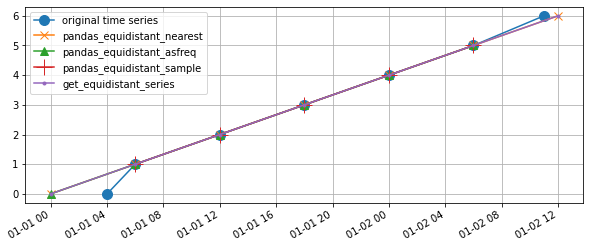

In [89]:
# Create time series
freq = "6H"
idx0 = pd.date_range("2000-01-01", freq=freq, periods=7).tolist()
idx0[0] = pd.Timestamp("2000-01-01 04:00:00")
idx0[-1] = pd.Timestamp("2000-01-02 11:00:00")
series = pd.Series(index=idx0, data=np.arange(len(idx0), dtype=float))

# Create equidistant time series with Pastas
s_pd1 = ps.ts.pandas_equidistant_sample(series, freq)
s_pd2 = ps.ts.pandas_equidistant_nearest(series, freq)
s_pd3 = ps.ts.pandas_equidistant_asfreq(series, freq)
s_pastas = ps.ts.get_equidistant_series(series, freq)

# Create figure
plt.figure(figsize=(10, 4))
ax = series.plot(
    marker="o",
    label="original time series",
    ms=10,
)
s_pd2.plot(ax=ax, marker="x", ms=8, label="pandas_equidistant_nearest")
s_pd3.plot(ax=ax, marker="^", ms=8, label="pandas_equidistant_asfreq")
s_pd1.plot(ax=ax, marker="+", ms=16, label="pandas_equidistant_sample")
s_pastas.plot(ax=ax, marker=".", label="get_equidistant_series")

ax.grid(True)
ax.legend(loc="best")
ax.set_xlabel("");

Both the `pandas_equidistant_nearest` and `pandas_equidistant_asfreq` methods and `get_equidistant_series` show the observations at the beginning and the end of the time series are shifted to the nearest equidistant timestamp. The `pandas_equidistant_sample` method drops 2 datapoints because they're measured at different time offsets.

In [90]:
# some helper functions to show differences in performance
def values_kept(s, original):
    diff = set(original.dropna().values) & set(s.dropna().values)
    return len(diff)

def n_duplicates(s):
    return (s.value_counts() >= 2).sum()

In [91]:
dfall = pd.concat([series, s_pd1, s_pd2, s_pd3, s_pastas], axis=1)
dfall.columns = [
    "original",
    "pandas_equidistant_sample",
    "pandas_equidistant_nearest",
    "pandas_equidistant_asfreq",
    "get_equidistant_series",
]
dfall

,original,pandas_equidistant_sample,pandas_equidistant_nearest,pandas_equidistant_asfreq,get_equidistant_series
2000-01-01 00:00:00,NaN,NaN,0.0,0.0,0.0
2000-01-01 04:00:00,0.0,NaN,NaN,NaN,NaN
2000-01-01 06:00:00,1.0,1.0,1.0,1.0,1.0
2000-01-01 12:00:00,2.0,2.0,2.0,2.0,2.0
2000-01-01 18:00:00,3.0,3.0,3.0,3.0,3.0
2000-01-02 00:00:00,4.0,4.0,4.0,4.0,4.0
2000-01-02 06:00:00,5.0,5.0,5.0,5.0,5.0
2000-01-02 11:00:00,6.0,NaN,NaN,NaN,NaN
2000-01-02 12:00:00,NaN,NaN,6.0,NaN,6.0


The following table summarizes the results, showing how many values from the original time series are kept and how many duplicates are contained in the final result.

In [92]:
valueskept = dfall.apply(values_kept, args=(dfall["original"],))
valueskept.name = "values kept"
duplicates = dfall.apply(n_duplicates)
duplicates.name = "duplicates"

pd.concat([valueskept, duplicates], axis=1)

,values kept,duplicates
original,7,0
pandas_equidistant_sample,5,0
pandas_equidistant_nearest,7,0
pandas_equidistant_asfreq,6,0
get_equidistant_series,7,0


#### Example 2

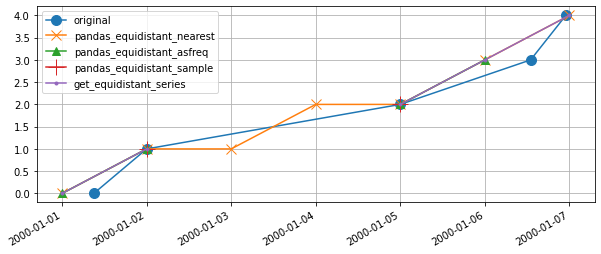

In [93]:
# Create timeseries
freq = "D"
idx0 = pd.date_range("2000-01-01", freq=freq, periods=7).tolist()
idx0[0] = pd.Timestamp("2000-01-01 09:00:00")
del idx0[2]
del idx0[2]
idx0[-2] = pd.Timestamp("2000-01-06 13:00:00")
idx0[-1] = pd.Timestamp("2000-01-06 23:00:00")
series = pd.Series(index=idx0, data=np.arange(len(idx0), dtype=float))

# Create equidistant timeseries
s_pd1 = ps.ts.pandas_equidistant_sample(series, freq)
s_pd2 = ps.ts.pandas_equidistant_nearest(series, freq)
s_pd3 = ps.ts.pandas_equidistant_asfreq(series, freq)
s_pastas = ps.ts.get_equidistant_series(series, freq)

# Create figure
plt.figure(figsize=(10, 4))
ax = series.plot(marker="o", label="original", ms=10)
s_pd2.plot(ax=ax, marker="x", ms=10, label="pandas_equidistant_nearest")
s_pd3.plot(ax=ax, marker="^", ms=8, label="pandas_equidistant_asfreq")
s_pd1.plot(ax=ax, marker="+", ms=16, label="pandas_equidistant_sample")
s_pastas.plot(ax=ax, marker=".", label="get_equidistant_series")
ax.grid(True)
ax.legend(loc="best")
ax.set_xlabel("");

In this example, the shortcomings of `pandas_equidistant_nearest` are clearly visible. It duplicates observations from the original timeseries to fill the gaps. This can be solved by passing e.g. `tolerance="0.99{freq}"` to `series.reindex()` in which case the gaps will not be filled. However, with very irregular timesteps this is not guaranteed to work and duplicates may still occur. The `pandas_equidistant_asfreq` and pastas methods work as expected and uses the available data to create a reasonable equidistant timeseries from the original data. The `pandas_equidistant_sample` method is only able to keep two observations from the original series in this example.

In [94]:
dfall = pd.concat([series, s_pd1, s_pd2, s_pd3, s_pastas], axis=1)
dfall.columns = [
    "original",
    "pandas_equidistant_sample",
    "pandas_equidistant_nearest",
    "pandas_equidistant_asfreq",
    "get_equidistant_series",
]
dfall

,original,pandas_equidistant_sample,pandas_equidistant_nearest,pandas_equidistant_asfreq,get_equidistant_series
2000-01-01 00:00:00,NaN,NaN,0.0,0.0,0.0
2000-01-01 09:00:00,0.0,NaN,NaN,NaN,NaN
2000-01-02 00:00:00,1.0,1.0,1.0,1.0,1.0
2000-01-03 00:00:00,NaN,NaN,1.0,NaN,NaN
2000-01-04 00:00:00,NaN,NaN,2.0,NaN,NaN
2000-01-05 00:00:00,2.0,2.0,2.0,2.0,2.0
2000-01-06 00:00:00,NaN,NaN,3.0,3.0,3.0
2000-01-06 13:00:00,3.0,NaN,NaN,NaN,NaN
2000-01-06 23:00:00,4.0,NaN,NaN,NaN,NaN
2000-01-07 00:00:00,NaN,NaN,4.0,NaN,4.0


The following table summarizes the results, showing how many values from the original time series are kept and how many duplicates are contained in the final result.

In [95]:
valueskept = dfall.apply(values_kept, args=(dfall["original"],))
valueskept.name = "values kept"
duplicates = dfall.apply(n_duplicates)
duplicates.name = "duplicates"

pd.concat([valueskept, duplicates], axis=1)

,values kept,duplicates
original,5,0
pandas_equidistant_sample,2,0
pandas_equidistant_nearest,5,2
pandas_equidistant_asfreq,4,0
get_equidistant_series,5,0


#### Example 3

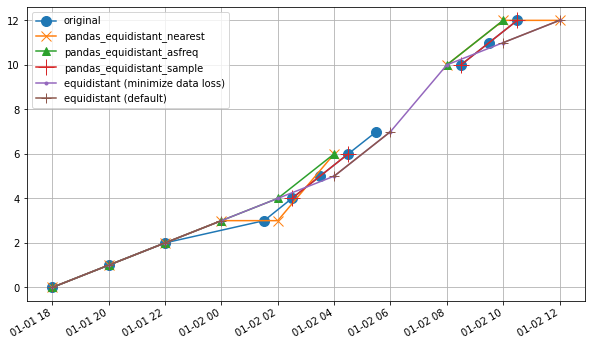

In [96]:
# Create timeseries
freq = "2H"
freq2 = "1H"
idx0 = pd.date_range("2000-01-01 18:00:00", freq=freq, periods=3).tolist()
idx1 = pd.date_range("2000-01-02 01:30:00", freq=freq2, periods=10).tolist()
idx0 = idx0 + idx1
idx0[3] = pd.Timestamp("2000-01-02 01:31:00")
series = pd.Series(index=idx0, data=np.arange(len(idx0), dtype=float))
series.iloc[8:10] = np.nan


# Create equidistant timeseries
s_pd1 = ps.ts.pandas_equidistant_sample(series, freq)
s_pd2 = ps.ts.pandas_equidistant_nearest(series, freq)
s_pd3 = ps.ts.pandas_equidistant_asfreq(series, freq)
s_pastas1 = ps.ts.get_equidistant_series(series, freq, minimize_data_loss=True)
s_pastas2 = ps.ts.get_equidistant_series(series, freq, minimize_data_loss=False)


# Create figure
plt.figure(figsize=(10, 6))
ax = series.plot(marker="o", label="original", ms=10)
s_pd2.plot(ax=ax, marker="x", ms=10, label="pandas_equidistant_nearest")
s_pd3.plot(ax=ax, marker="^", ms=8, label="pandas_equidistant_asfreq")
s_pd1.plot(ax=ax, marker="+", ms=16, label="pandas_equidistant_sample")
s_pastas1.plot(ax=ax, marker=".", ms=6, label="get_equidistant_series (minimize data loss)")
s_pastas2.plot(ax=ax, marker="+", ms=10, label="get_equidistant_series (default)")
ax.grid(True)
ax.legend(loc="best")
ax.set_xlabel("");

In this example we can observe the following behavior in each method:
- `pandas_equidistant_sample` retains 4 values.
- `pandas_equidistant_nearest` duplicates some observations in the equidistant timeseries.
- `pandas_equidistant_asfreq` does quite well, but drops some observations near the gap in the original timeseries.
- `get_equidistant_series` method misses an observation right after the gap in the original timeseries.
- `get_equidistant_series` with `minimize_data_loss=True` fills this gap, using as much data as possible from the original timeseries.

The results from the `pandas_equidistant_asfreq` and `get_equidistant_series` methods both work well, but the latter method retains more of the original data.

In [97]:
dfall = pd.concat([series, s_pd1, s_pd2, s_pd3, s_pastas2, s_pastas1], axis=1)
dfall.columns = [
    "original",
    "pandas_equidistant_sample",
    "pandas_equidistant_nearest",
    "pandas_equidistant_asfreq",
    "get_equidistant_series (default)",
    "get_equidistant_series (minimize data loss)",
]
dfall

,original,pandas_equidistant_sample,pandas_equidistant_nearest,pandas_equidistant_asfreq,get_equidistant_series (default),get_equidistant_series (minimize data loss)
2000-01-01 18:00:00,0.0,NaN,0.0,0.0,0.0,0.0
2000-01-01 18:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-01 20:00:00,1.0,NaN,1.0,1.0,1.0,1.0
2000-01-01 20:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-01 22:00:00,2.0,NaN,2.0,2.0,2.0,2.0
2000-01-01 22:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-02 00:00:00,NaN,NaN,3.0,3.0,3.0,3.0
2000-01-02 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-02 01:31:00,3.0,NaN,NaN,NaN,NaN,NaN
2000-01-02 02:00:00,NaN,NaN,3.0,4.0,NaN,4.0


The following table summarizes the results, showing how many values from the original time series are kept and how many duplicates are contained in the final result.

In [98]:
valueskept = dfall.apply(values_kept, args=(dfall["original"],))
valueskept.name = "values kept"
duplicates = dfall.apply(n_duplicates)
duplicates.name = "duplicates"

pd.concat([valueskept, duplicates], axis=1)

,values kept,duplicates
original,11,0
pandas_equidistant_sample,4,0
pandas_equidistant_nearest,7,2
pandas_equidistant_asfreq,8,0
get_equidistant_series (default),8,0
get_equidistant_series (minimize data loss),10,0


#### Example 4

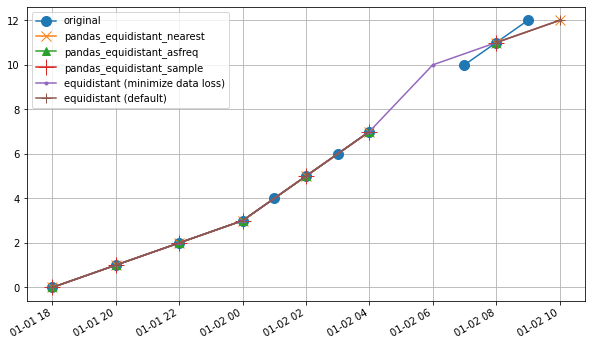

In [99]:
# Create timeseries
freq = "2H"
freq2 = "1H"
idx0 = pd.date_range("2000-01-01 18:00:00", freq=freq, periods=3).tolist()
idx1 = pd.date_range("2000-01-02 00:00:00", freq=freq2, periods=10).tolist()
idx0 = idx0 + idx1
series = pd.Series(index=idx0, data=np.arange(len(idx0), dtype=float))
series.iloc[8:10] = np.nan

# Create equidistant timeseries
s_pd1 = ps.ts.pandas_equidistant_sample(series, freq)
s_pd2 = ps.ts.pandas_equidistant_nearest(series, freq)
s_pd3 = ps.ts.pandas_equidistant_asfreq(series, freq)
s_pastas1 = ps.ts.get_equidistant_series(series, freq, minimize_data_loss=True)
s_pastas2 = ps.ts.get_equidistant_series(series, freq, minimize_data_loss=False)

# Create figure
plt.figure(figsize=(10, 6))
ax = series.plot(marker="o", label="original", ms=10)
s_pd2.plot(ax=ax, marker="x", ms=10, label="pandas_equidistant_nearest")
s_pd3.plot(ax=ax, marker="^", ms=8, label="pandas_equidistant_asfreq")
s_pd1.plot(ax=ax, marker="+", ms=16, label="pandas_equidistant_sample")
s_pastas1.plot(ax=ax, marker=".", ms=6, label="get_equidistant_series (minimize data loss)")
s_pastas2.plot(ax=ax, marker="+", ms=10, label="get_equidistant_series (default)")
ax.grid(True)
ax.legend(loc="best")
ax.set_xlabel("");

Similar to the previous example, `get_equidistant_timeseries` retains the most data from the original timeseries. In this case both the `pandas_equidistant_asfreq`  and `pandas_equidistant_nearest` methods perform well, but do omit some of the original data at the end of the timeseries or near the gap in the original timeseries.

In [100]:
dfall = pd.concat([series, s_pd1, s_pd2, s_pd3, s_pastas2, s_pastas1], axis=1)
dfall.columns = [
    "original",
    "pandas_equidistant_sample",
    "pandas_equidistant_nearest",
    "pandas_equidistant_asfreq",
    "get_equidistant_series (default)",
    "get_equidistant_series (minimize data loss)",
]
dfall

,original,pandas_equidistant_sample,pandas_equidistant_nearest,pandas_equidistant_asfreq,get_equidistant_series (default),get_equidistant_series (minimize data loss)
2000-01-01 18:00:00,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-01 20:00:00,1.0,1.0,1.0,1.0,1.0,1.0
2000-01-01 22:00:00,2.0,2.0,2.0,2.0,2.0,2.0
2000-01-02 00:00:00,3.0,3.0,3.0,3.0,3.0,3.0
2000-01-02 01:00:00,4.0,NaN,NaN,NaN,NaN,NaN
2000-01-02 02:00:00,5.0,5.0,5.0,5.0,5.0,5.0
2000-01-02 03:00:00,6.0,NaN,NaN,NaN,NaN,NaN
2000-01-02 04:00:00,7.0,7.0,7.0,7.0,7.0,7.0
2000-01-02 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-02 06:00:00,NaN,NaN,NaN,NaN,NaN,10.0


The following table summarizes the results, showing how many values from the original time series are kept and how many duplicates are contained in the final result.

In [101]:
valueskept = dfall.apply(values_kept, args=(dfall["original"],))
valueskept.name = "values kept"
duplicates = dfall.apply(n_duplicates)
duplicates.name = "duplicates"

pd.concat([valueskept, duplicates], axis=1)

,values kept,duplicates
original,11,0
pandas_equidistant_sample,7,0
pandas_equidistant_nearest,8,0
pandas_equidistant_asfreq,7,0
get_equidistant_series (default),8,0
get_equidistant_series (minimize data loss),9,0


### Creating equidistant time series for fluxes

# TODO: Ruben

- timestamp_weighted_resample, example with monthly pumping data to daily freq (upsampling)
- timestamp_weighted_resample, precipitation at 9am-9am -> 12am-12am (shift)
- timestamp_weighted_resample, hourly -> daily (downsampling)
